# Tittle: Identification of Marker Genes in Human Breast Tumors using scRNA 
## Introduction

Tamoxifen is a selective estrogen receptor modulator (SERM) medication used to treat breast cancer. breast cancer is a major type of cancer in females. Detecting cancer early poses a significant challenge due to its inherent heterogeneity. In ER-positive, HER2-negative breast cancer, multiple measures of intra-tumor heterogeneity are associated with worse response to endocrine therapy

Recent progress in next-generation technologies has facilitated the exploration of novel gene expressions involved in breast cancer pathogenesis. The utilization of Next-Generation Sequencing (NGS) methods has generated extensive datasets, necessitating computationally intensive analyses. Consequently, machine learning models have been deployed to effectively analyze these large datasets. Machine learning algorithms have demonstrated their effectiveness and computational efficiency in identifying disease biomarkers from high-dimensional datasets.

In this project, we leverage a single-cell-RNA dataset combined with machine learning techniques to identify and determine breast cancer biomarkers. To identify gene signatures associated with breast cancer for six different types of breast cancer tumors, we will use Scanpy.


##  Dataset

The dataset under consideration comprises samples from the population of live human tumors and normal breast specimens tha were taken immediately after surgical resection for processing into single-cell workflows for experimentation and genomic analyses.I this study, we show differences in tamoxifen response by cell type. The data set was obtained from NCBI GEO database under the accession number GSE245601

## Methodology
- Data Acqusition: h5 format
- Preprocessing and Quality control: Gene, cell and mitochondria filtering
- Clustering: UMAP
- Data Visualization: Dot plots,violin, track plots,scatter plots, heatmaps
- Benchmarking: Literature Search

## Workflow

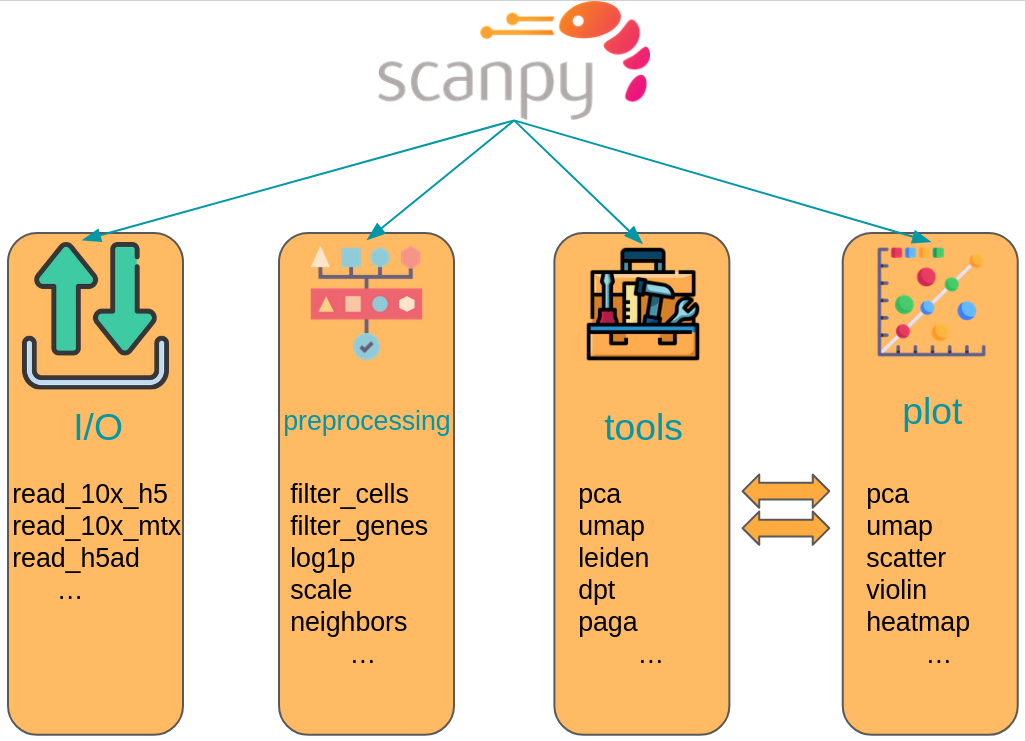

In [344]:
from IPython.display import Image, display

# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = 'scanpy_set_up.png'

# Display the image
display(Image(filename=image_path))


*Workflow Figure was adapted from https://www.sc-best-practices.org/introduction/analysis_tools.html*

# Data Acquisition
The datset was downloaded using ftp commandline as follows
Counts data

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

The counts data represent the number of RNA sequencing reads that have been aligned to each gene in the transcriptome. These counts can be indicative of the level of gene expression in the samples. The file contains gene expression data in the form of counts, derived from RNA sequencing experiments

Normalized counts data
! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

This file likely contains normalized gene expression data from the same RNA sequencing experiments.
Normalization is a process used to adjust for technical variations between samples, allowing for more accurate comparisons of gene expression levels across different experimental conditions or samples.


## Preprocessing
USe of Scanpy

In [274]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import scipy
import scipy.io as sio
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)# supress some warnings
sc.settings.verbosity = 3


In [275]:
import h5py
import os

# folder_path = "/path/to/your/files"
output_file = "output.h5"
folder_path = "../data/"

output_file = "../data/output.h5"

# Get a list of H5 files in the folder
d_names = [f for f in os.listdir(folder_path) if f.endswith('Control.h5')]

# Dictionary to store the database structure
d_struct = {}

# Iterate over H5 files and get group names
for i in d_names:
    path = os.path.join(folder_path, i)
    print(path)

    with h5py.File(path, 'r') as f:
        d_struct[i] = list(f.keys())

# Create the output H5 file
with h5py.File(output_file, 'w') as outfile:
    # Iterate over H5 files and copy datasets to the output file
    for i in d_names:
        path = os.path.join(folder_path, i)
        with h5py.File(path, 'r') as f:
            for j in d_struct[i]:
                # Check if the dataset already exists in the output file
                if j in outfile:
                    print(f"Dataset '{j}' already exists in the output file. Skipping.")
                else:
                    # Copy dataset from the original file to the output file
                    f.copy(j, outfile, name=j)

print("Datasets copied successfully.")

../data/GSM7845546_Normal_01_Control.h5
../data/GSM7845548_Normal_02_Control.h5
../data/GSM7845550_T47D_Control.h5
../data/GSM7845552_Tumor_01_Control.h5
../data/GSM7845554_Tumor_02_Control.h5
../data/GSM7845556_Tumor_03_Control.h5
../data/GSM7845558_Tumor_04_Control.h5
../data/GSM7845560_Tumor_05_Control.h5
../data/GSM7845562_Tumor_06_Control.h5
../data/GSM7845564_Tumor_07_Control.h5
../data/GSM7845566_Tumor_08_Control.h5
../data/GSM7845568_Tumor_09_Control.h5
../data/GSM7845570_Tumor_10_Control.h5
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.
Dataset 'matrix' already exists in the output file. Skipping.

In [276]:
#Load data

data= sc.read_10x_h5("../data/output.h5")
data

reading ../data/output.h5
 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4267 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

Number of cells (observations or n_obs): 4267

Number of genes (variables or n_vars): 33538

In [277]:
# data
#check total number of mitochondrial genes in the dataset
data.var_names.str.contains("MT-").sum()

14

In [278]:
 # annotate the group of mitochondrial genes as 'MT'
data.var['MT'] = data.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(data, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [279]:
data.var

,gene_ids,feature_types,genome,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,14,0.003281,99.671901,14.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,2,0.000469,99.953129,2.0
...,...,...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,228,0.067260,94.656667,287.0
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0


In [280]:
#make the gene names unique
data.var_names_make_unique()

## Exploratory Data Analysis
- Mitochondrial gene composition.
Mitochondrial genes often start with "MT-" or "MTRNR," and their inclusion helps estimate the mitochondrial composition of each cell. Most of the cells have a mitochondria count percentage below 15%. The cells with higher than 15% mitochondria count may signify cell stress and damage and were therefore filterd out.
- Cell counts. Cells with less than 500 genes were excluded from downstream analysis. The low gene count in cells can be due to low capture, inefficient cell lysis or non-viable cells.
Each violin plot represents the distribution of the number of genes expressed per cell.
- Gene counts
- Cells with less than 20000 total count were excluded from the analysis.


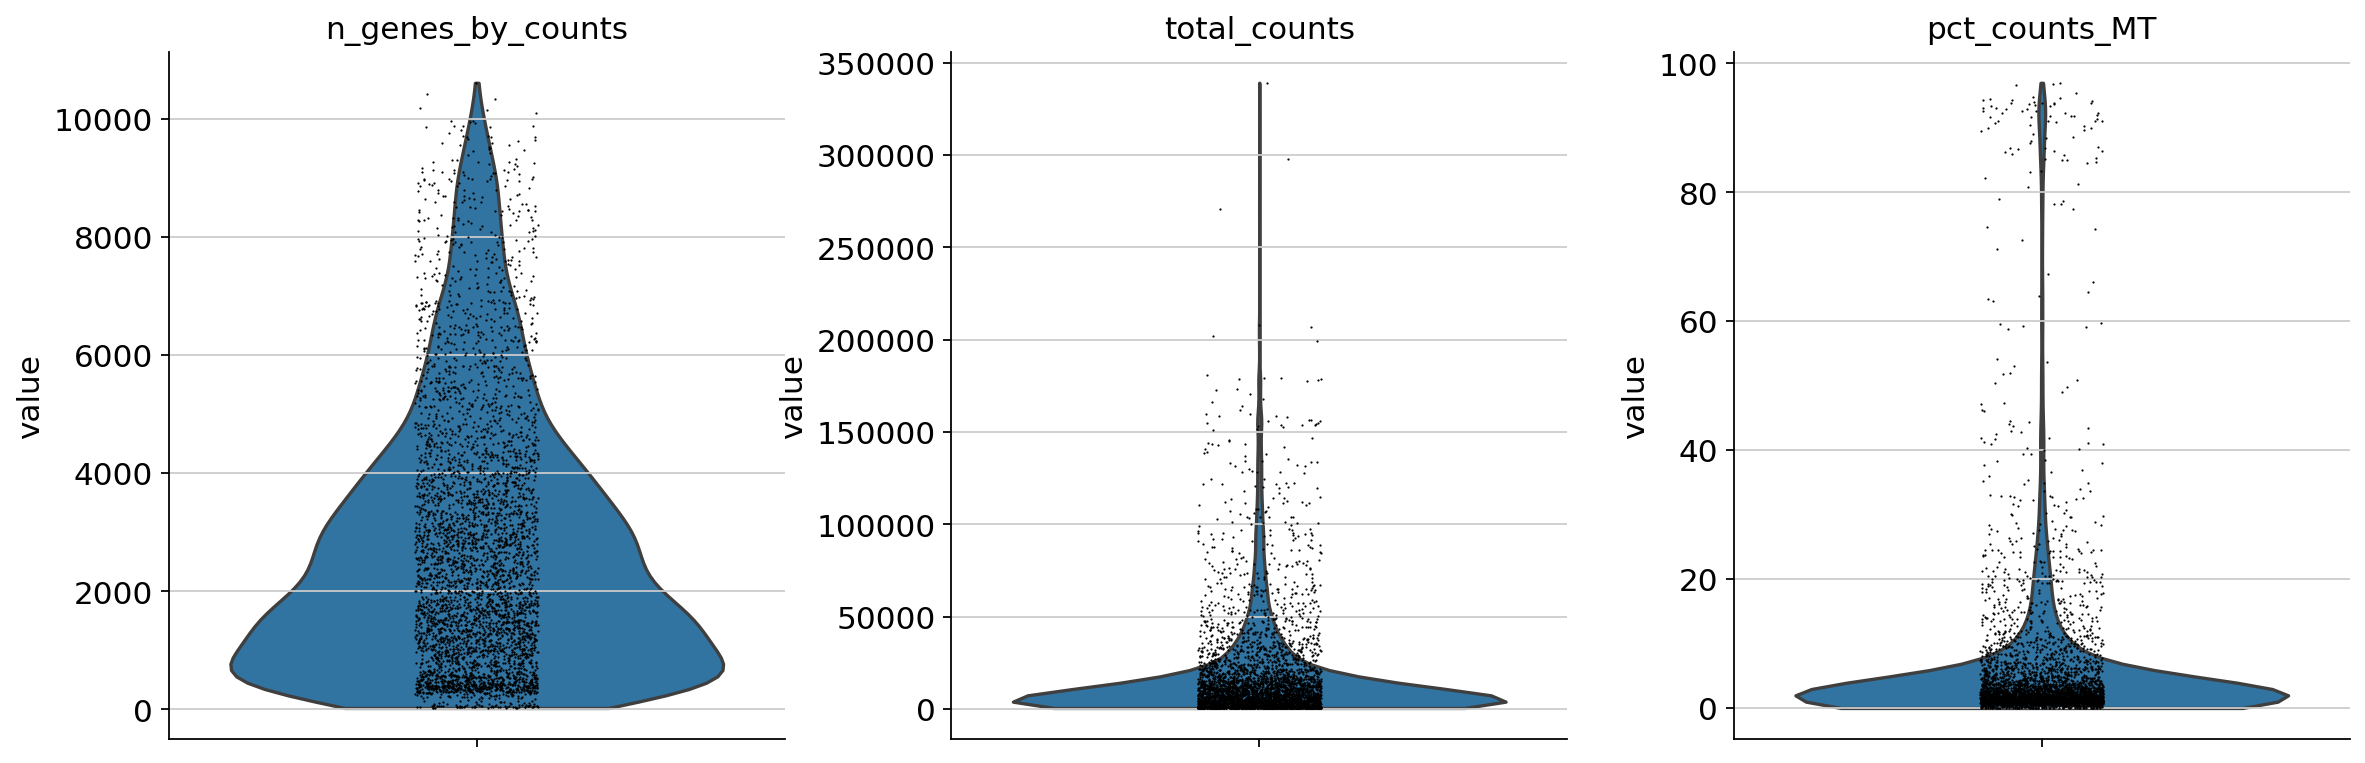

In [281]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True,
    save='_gene_MT_vs_transcript_counts'
)



The plots indicate that some reads have a relatively high percentage of mitochondrial counts which are often associated with cell degradation. However, most of the cells have less than 15% mitochondria percentage which. We can also observe most cells have total counts of below 20000. For gene counts per cell, most cells approximately contain about 5000 gene counts on average. These visualizations were used to set the quality control thresholds. We also filter out genes that are not detected in at least 20 cells as these are not informative.

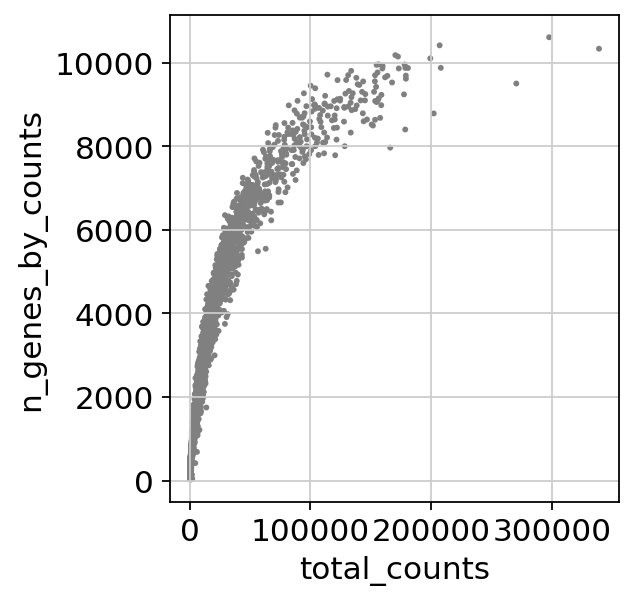

In [282]:
sc.pl.scatter(data, "total_counts", "n_genes_by_counts", save='_gene_vs_total_counts')

The scatter plot shows gene counts per each gene. The output shows presence of potential outliers for gene counts

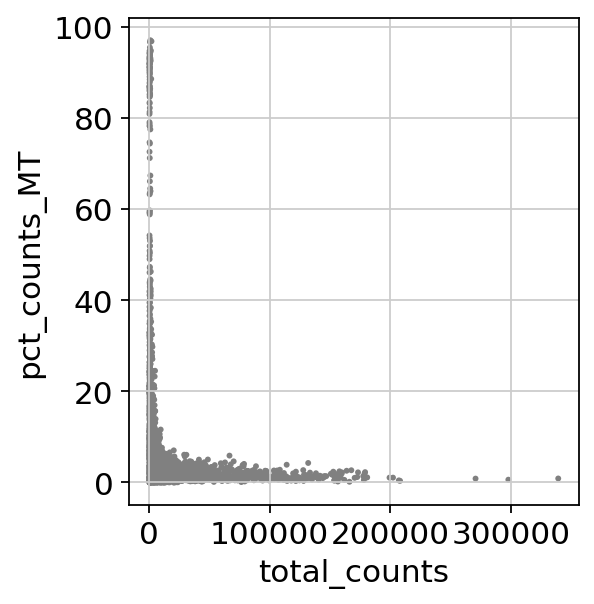

In [283]:
sc.pl.scatter(data, "total_counts", "pct_counts_MT")

From the scatter plot, few cells have mitochondria composition between 0-50000

# Quality Control

In [284]:
# Filter the data
data = data[data.obs.n_genes_by_counts < 5000,:]
data = data[data.obs.total_counts < 20000,:]
data = data[data.obs.pct_counts_MT < 15,:]
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(data, min_cells=20)
data.shape # Checking number of cells remaining

filtered out 19290 genes that are detected in less than 20 cells


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


(2972, 14248)

After filtering, the number of genes remaining is 2972 and the number of cells remainaing is 33538

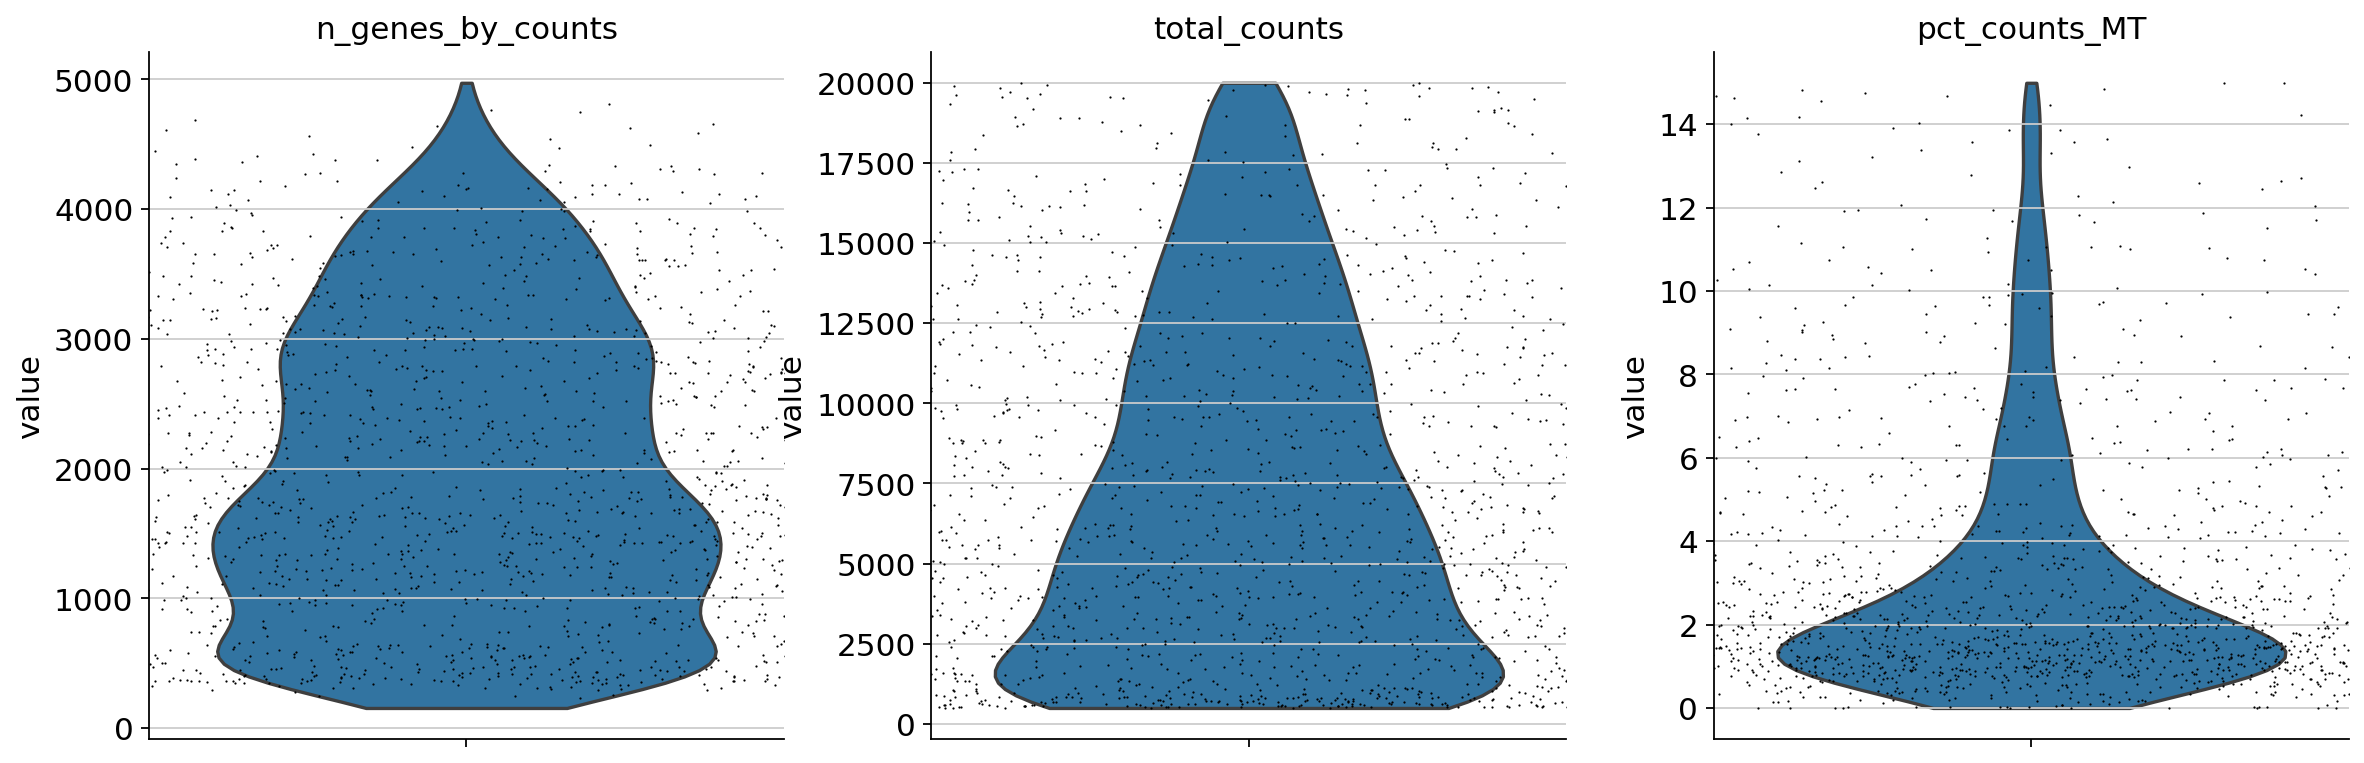

In [285]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    jitter=1,
    multi_panel=True,
    save='Filtered_gene_MT_vs_transcript_counts'
   
)


After the quality control, we can see the interquartile ranges for gene counts, total counts and mitochondria composition are within the expected ranges based on the previous filtered parameters. 

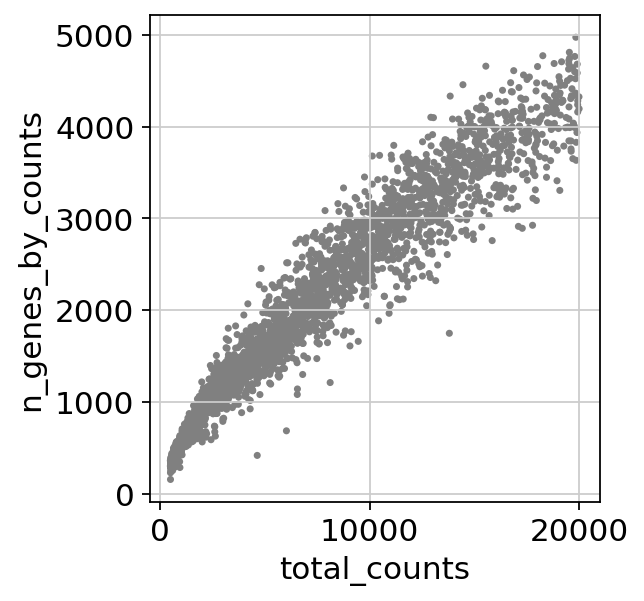

In [286]:
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts', save='_Filtered_gene_vs_transcript_counts')

## Normalization
This step is performed to account for technical biases and variability across cells, ensuring that the observed differences in gene expression are reflective of biological signals rather than technical artifacts. For example
- Each cell in a scRNA-seq experiment may have a different number of RNA molecules, resulting in variability in library sizes
-  samples are processed at different times, and batch effects can introduce unwanted variability.
-   Longer genes generally produce more sequencing reads, and some cells may be sequenced more deeply than others.
-   Technical variations such as amplification bias, and sequencing biases
  
In this project, transcripts per million (TPm) normalization and log normalization have been used. The log normalization was adopted since scRNA has high variance.

In [287]:
#normarization
data.layers["counts"] = data.X.copy() # preserve counts
sc.pp.normalize_total(data, target_sum=1e6) # scale each cell to a common library size
sc.pp.log1p(data) # log(expression + 1)
data.raw = data # freeze the state in `.raw`


normalizing counts per cell
    finished (0:00:00)


# Gene counts after QC

In [288]:
print("min_gene count is ", data.obs["n_genes_by_counts"].min(), "\n max_gene count is ",data.obs["n_genes_by_counts"].max())

min_gene count is  155 
 max_gene count is  4974


In [289]:
data.obs["n_genes_by_counts"].max()

4974

# Highly variable genes
Discarding non-significant genes that are equally expressed across the cells is a preprocessing step in scRNA-seq analysis. This process is performed to reduce noise, to focus on the most informative genes, and improve the efficiency of downstream analyses. After extracting highly variable genes, we see that only 6684 genes remained for downstream analysis.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


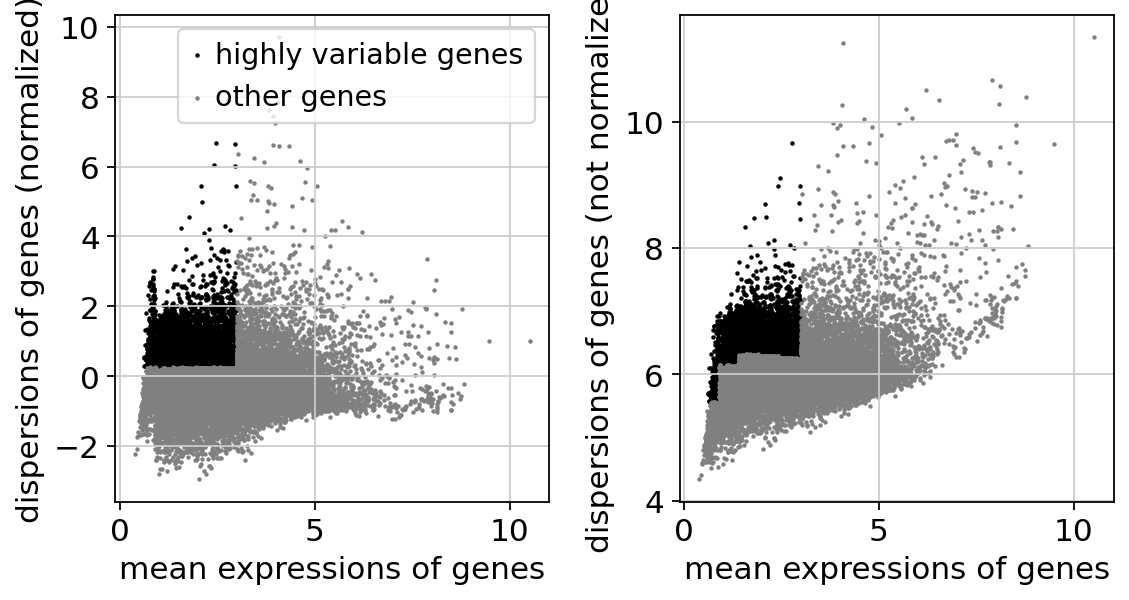

In [290]:
#determining High variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(data, save='') # scanpy generates the filename automatically

In [291]:
data

AnnData object with n_obs × n_vars = 2972 × 14248
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [292]:
data.raw=data
data = data[:, data.var['highly_variable']]
sc.pp.scale(data, zero_center=True, max_value=3)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [293]:
print("min_nom",data.var["dispersions_norm"].min(),"\nmax_norm is",data.var["dispersions_norm"].max())

min_nom 0.25018993 
max_norm is 7.9066873


In [294]:
data.var_vector

<bound method AnnData.var_vector of AnnData object with n_obs × n_vars = 2972 × 3259
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts'>

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


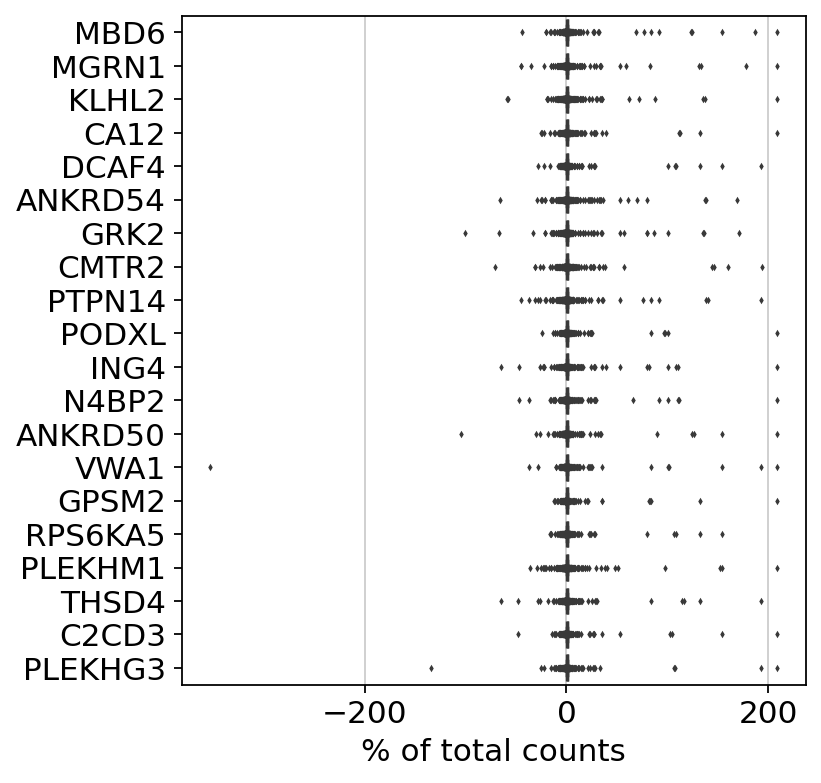

In [336]:
sc.pl.highest_expr_genes(data, n_top=20)

From thr plots, among highly variable genes are MBD6M,MGRN1, KLHL2,CAI1,DCAF4

## Clustering of highly variable genes
Leiden algorithm was be used for hierarchical clustering, allowing for to discover and characterize cell types or states within a heterogeneous sample.

In [296]:
# Extracting top 1500 genes
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)
top_1500Genes

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## UMPA clustering
UMAP was used as an effective preprocessing step to boost the performance of density based clustering.
## steps
- Obtain highly variable genes
- Rank the genes in order of counts
- Cluster the genes into distinct groups
- Rank the genes in each cluster


In [297]:
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.tl.leiden(data, key_added="clusters")

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:06)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 12 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:04)


In [298]:
sc.tl.leiden(data)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [299]:
# sc.pl.umap(data, color=['leiden'], legend_fontsize=8, save='_leiden')

In [300]:

import scanpy as sc
import pandas as pd
from matplotlib import rcParams

sc.tl.rank_genes_groups(data, 'leiden', method='t-test')

# The head function returns the top n genes per cluster
top_markers = pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)
print(top_markers)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
         0       1         2        3         4       5      6       7      8  \
0     CTSL  IGFBP7  C11orf96      DCN      AREG   KRT18  KRT17   CXCR4   KRT7   
1    GSTO1  C2CD4B   TNFAIP6      GEM  ANKRD30A  SPINT2  KRT14   HLA-B   CD24   
2    PRRX1    SELE       GEM  GADD45B     PLCG2   CLDN7   KRT5   HLA-C  KRT18   
3    MEDAG   GNG11      APOD     FOSB     AZGP1  TM4SF1   TPM1  TMSB4X   SAA1   
4  TNFAIP6  ANGPT2       DCN   LGALS1    MALAT1    KRT8   KRT7     B2M  CLDN4   

         9        10        11  
0     AREG   TNFAIP6  HLA-DQA1  
1  SERTAD1       GEM      SRGN  
2    RBM39     ANXA5      CTSL

In [301]:
sc.set_figure_params(dpi=80, color_map='viridis')
sc.settings.verbosity = 2
# sc.logging.print_versions()

In [302]:
rcParams['figure.figsize'] = 4, 4

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


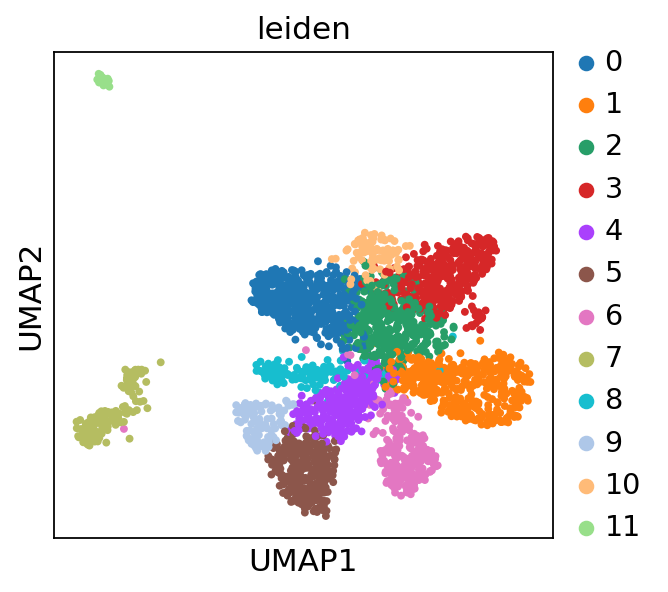

In [334]:
# plot umap for the top genes per cell type
sc.pl.umap(data, color=['leiden'], s=50)

The UMAP clustering shows 11 distinct cell categories. In the next steps, we are going to unpack each category to determine which genes are differentially expressed in the cell categories.

# Top Marker genes  per category
The top gene per category of cells have been extracted for spatial analysis i.e to get the patterns of tgeir distribution in other cells. From the results of the marker gene extraction after log nomalization and quakity control, CTSL gene is the most variable gene across the cell types.

In [340]:
marker_genes = ['CTSL', 'DCN', 'CD24', 'C2CD4B', 'AREG','KRT8','KRT18', 'TNFAIP6', 'KRT17', 'CXCR4',
                'IGFBP7', 'C11orf96', 'SRGN','HLA-DQA1']

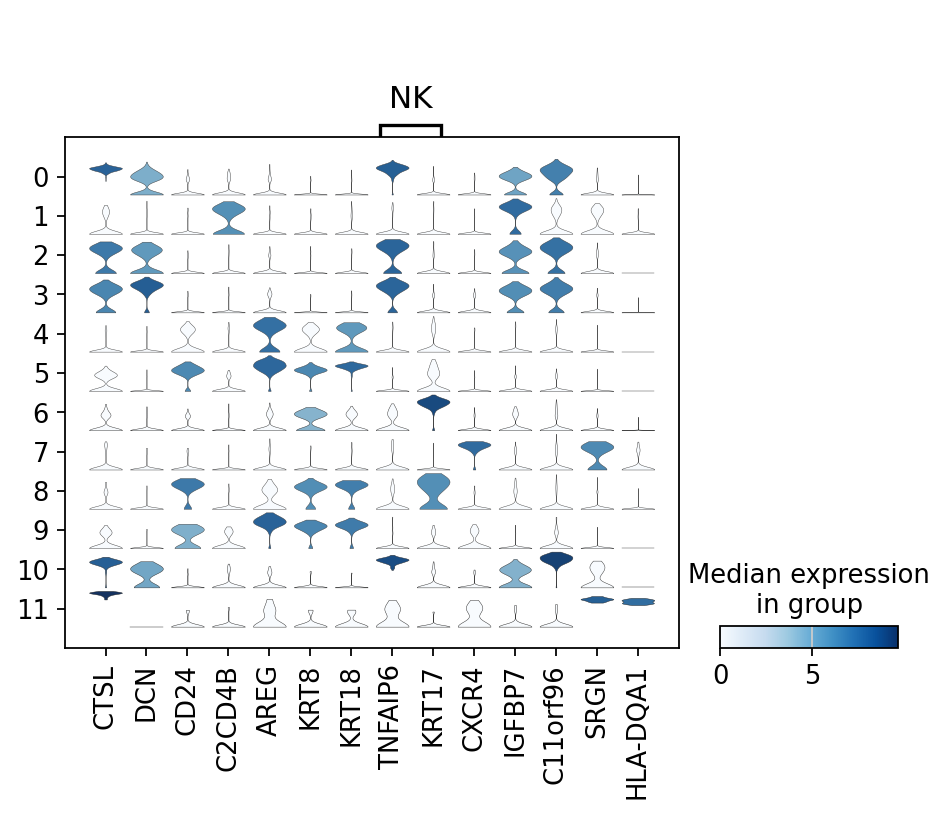

In [341]:
# Marker genes per cluster
ax = sc.pl.stacked_violin(data, marker_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['NK'])

We can see that genes such as C2CD4B are unqiuely differentially expressed in specific categories while genes such as CTSL are expressed in more than one type of cells in clusters 10,5,1 and 0. We can visualize the gene clustering using a dot plot with a dendrogram
to show the relatedness and level of the gene expression across different cells as shown below. Track plot also shows the gene expression profiles using baar graphs as shown below.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


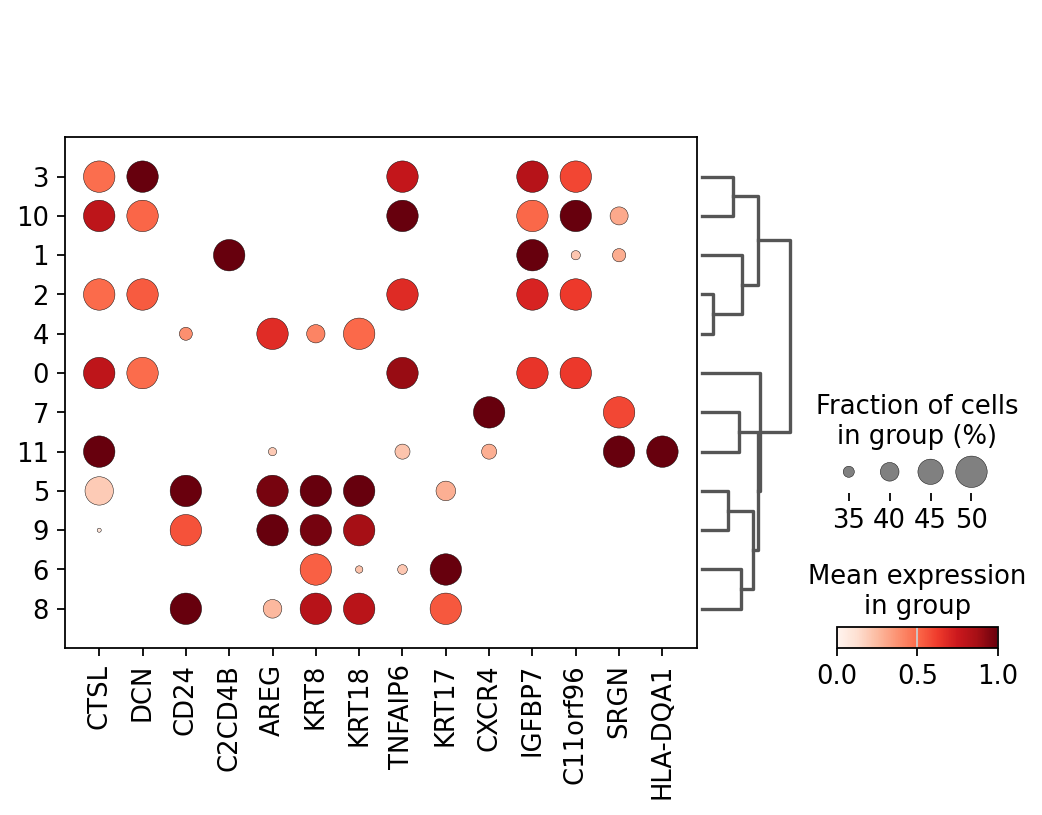

In [342]:
ax = sc.pl.dotplot(data, marker_genes, groupby='leiden', dendrogram=True, dot_max=0.5, dot_min=0.3, standard_scale='var')

From the dot plot and using the top selected genes per cluster, expression patterns in clusters 8 and 9 are closer than other expression patterns. Also, classes 2 and 10 are closely related in their expression patterns.  Among the cell types, CTSL is the highest expressed in all the six cell types. AREG gene is highly expressed in two cell types for clusters 9 and 5. The output also suggests co-expression patterns for KRT8 and KRT18. This is evident by the fact that clusters that show differential expression for the AREG gene also have differential expression of the KRT18 gene. Some genes are also shown to be interrelated and may be involved in similar metabolic pathways. For example. In cluster 11, CTSL, SRGN, and HLA-DQA1 are highly expressed and their overexpressed seems to cause the underexpression of AREG, TNFA1P6, and CXCR4. 

We can also see the CD8 to be one of the high

# Cell types based on marker genes

We can use the marker gene to identify the cell types. These marker genes were obtained from the literature.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, T-cell, T-cell CD8+, etc.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


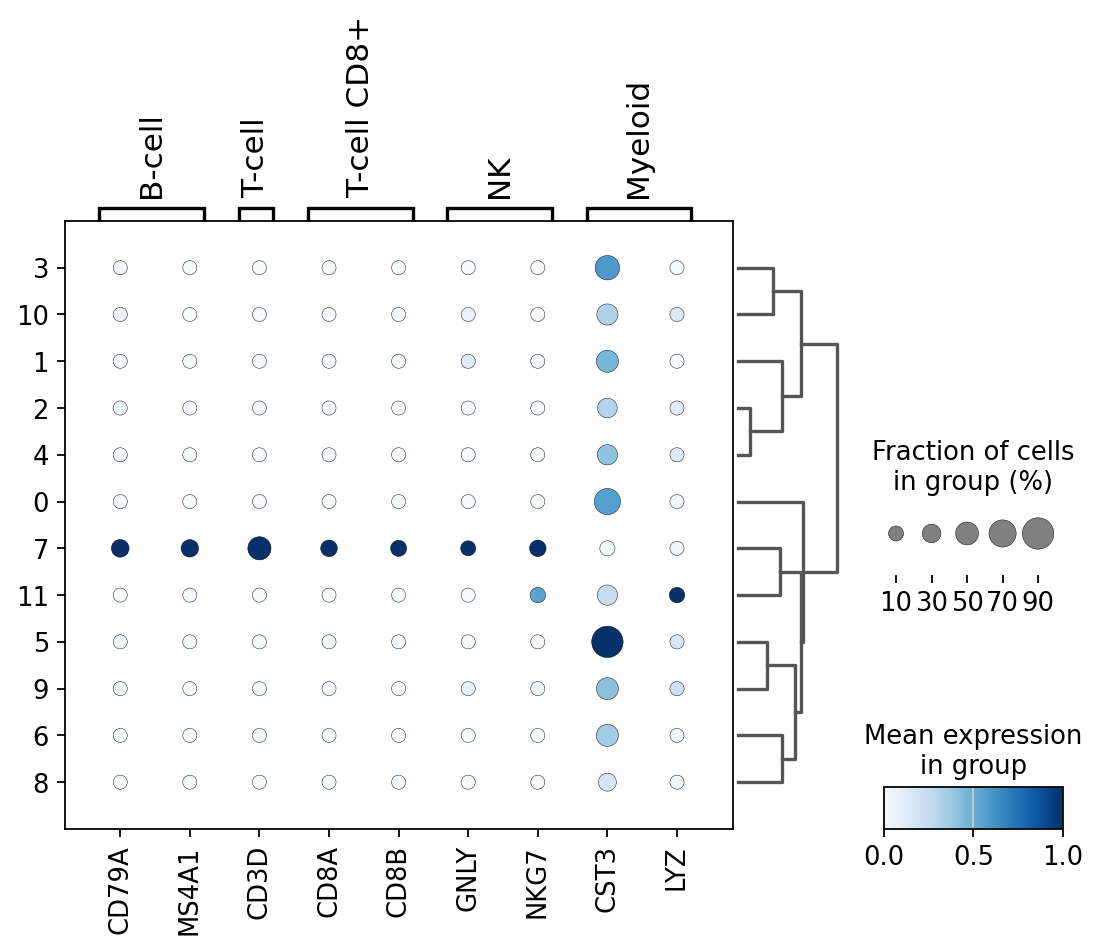

In [324]:

marker_genes_dict = {'B-cell': ['CD79A', 'MS4A1'],
                     'T-cell': 'CD3D',
                     'T-cell CD8+': ['CD8A', 'CD8B'],
                     'NK': ['GNLY', 'NKG7'],
                     'Myeloid': ['CST3', 'LYZ']
                     # 'Monocytes': ['FCGR3A'],
                     # 'Dendritic': ['FCER1A']
                    }


ax = sc.pl.dotplot(data, marker_genes_dict, groupby='leiden', dendrogram=True,
                   standard_scale='var', smallest_dot=40, color_map='Blues', figsize=(8,5))

# Track plots
Track plots is another way of visualizing expression patterns of genes per cell type

In [325]:
# Track plot data is better visualized using the non-log counts
import numpy as np
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

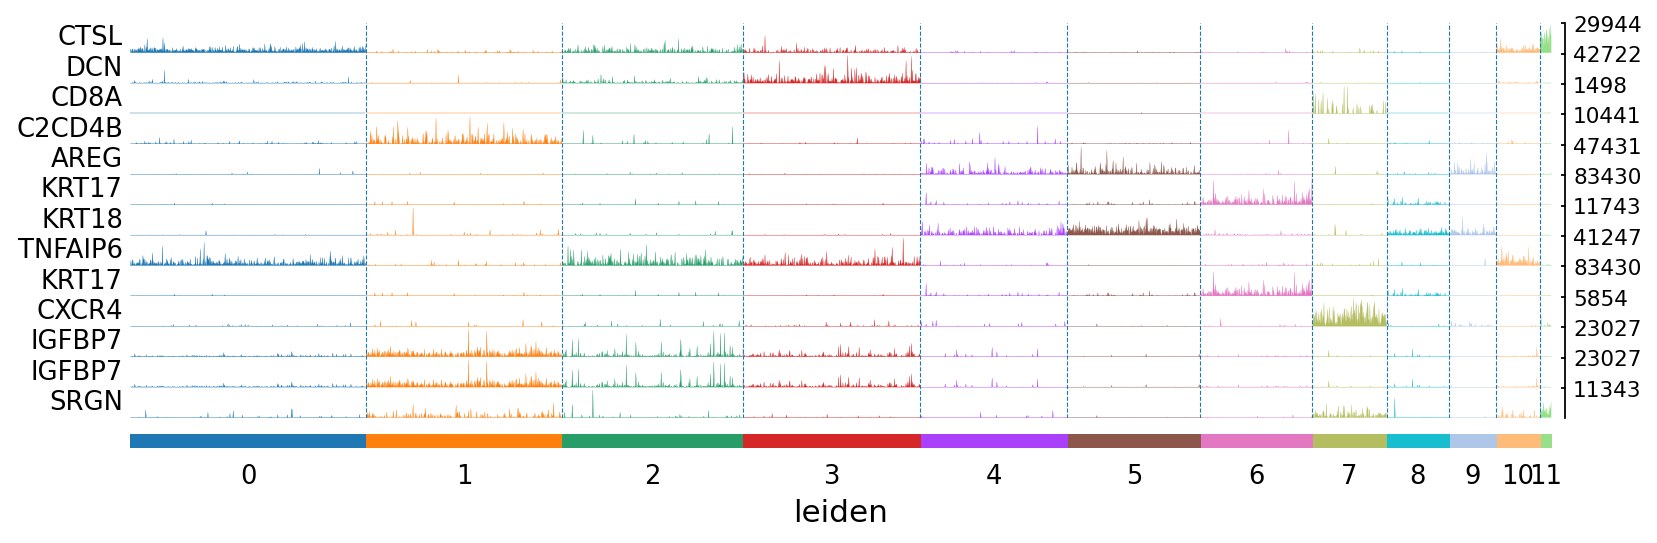

In [326]:
ax = sc.pl.tracksplot(ad,marker_genes, groupby='leiden')

# We can see similar expression patterns in clusster 2  and 3 

# Marker gene Visualization

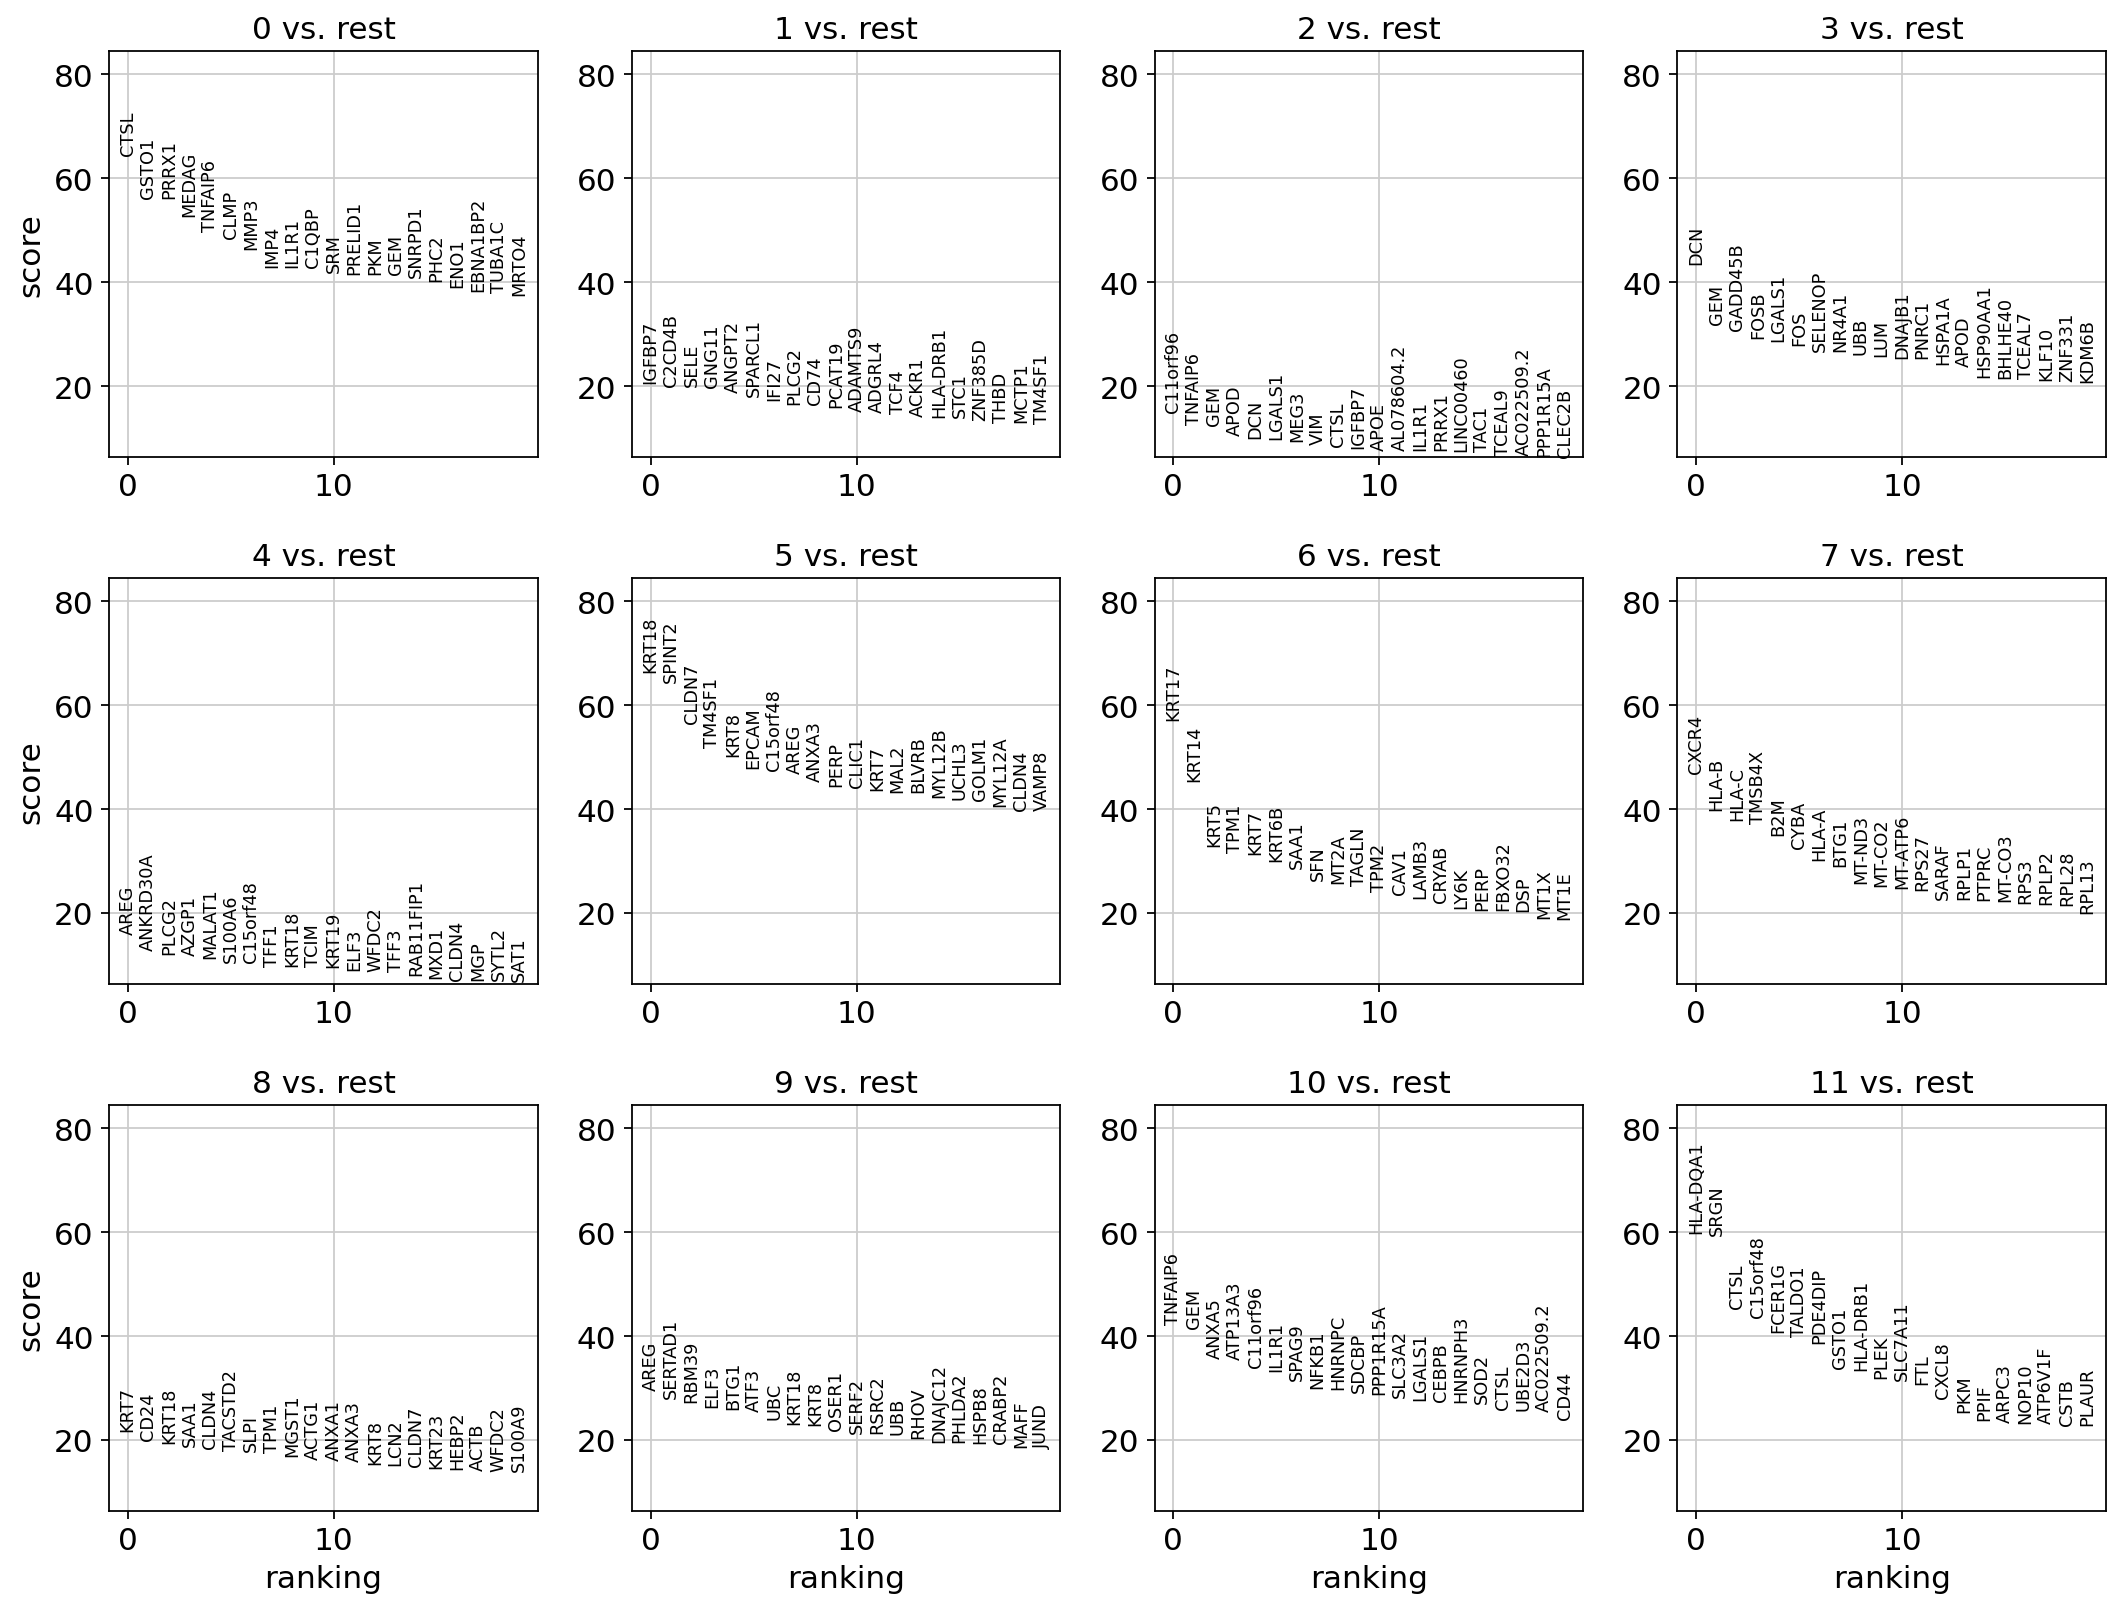

In [327]:
#v one vs rest visualization
rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(data)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


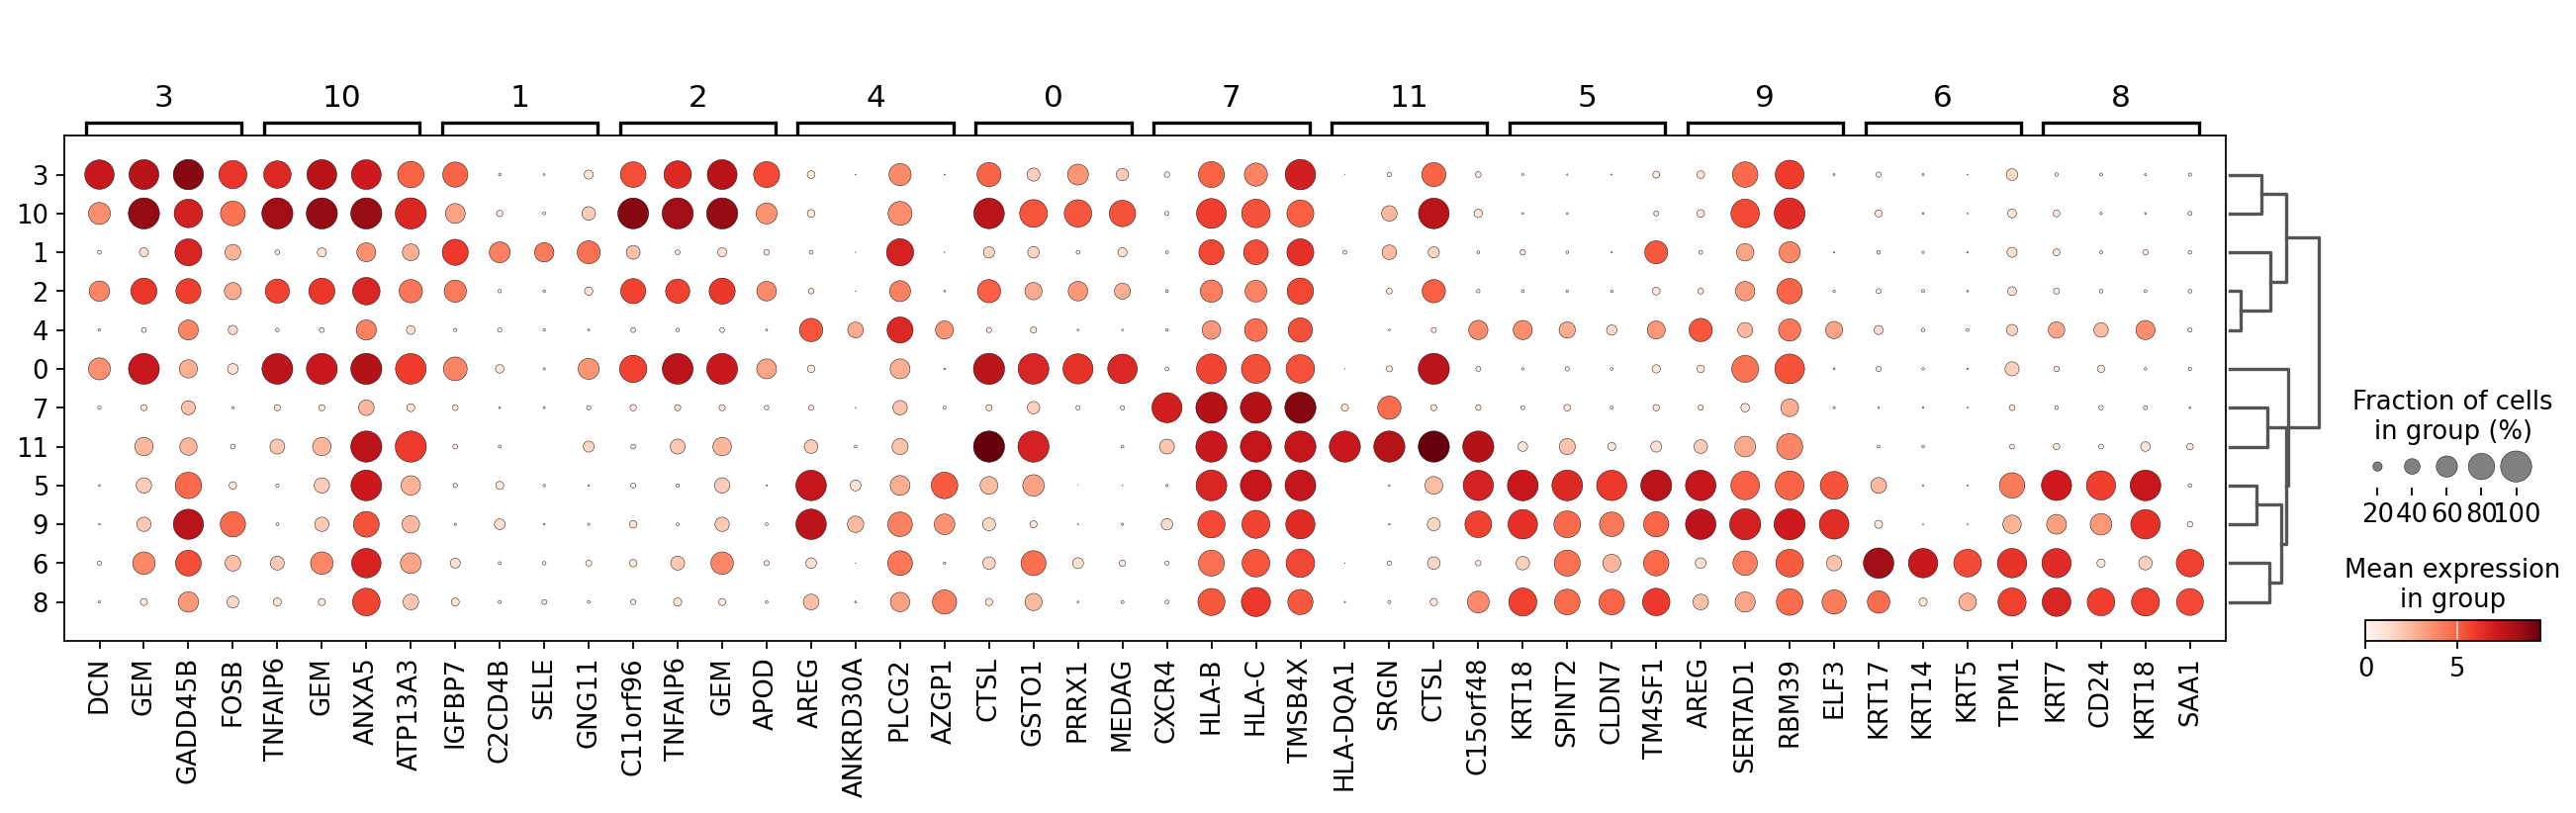

In [320]:
sc.pl.rank_genes_groups_dotplot(data, n_genes=4)

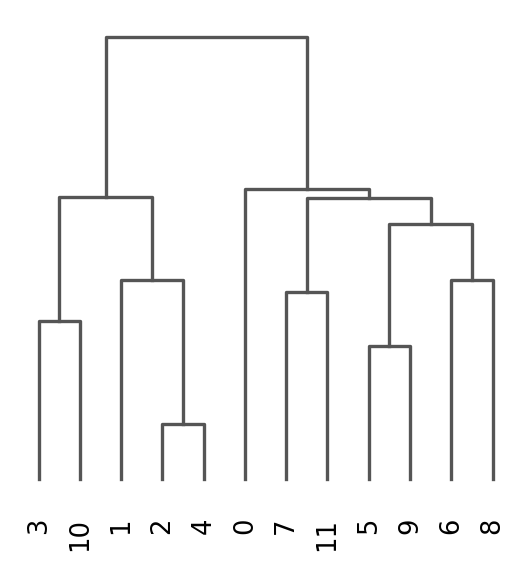

In [318]:
ax = sc.pl.dendrogram(data, 'leiden')

# Heat Map for differentially exprssed genes per  cell type category

ranking genes
    finished (0:00:01)
categories: 0, 1, 2, etc.
var_group_labels: 5


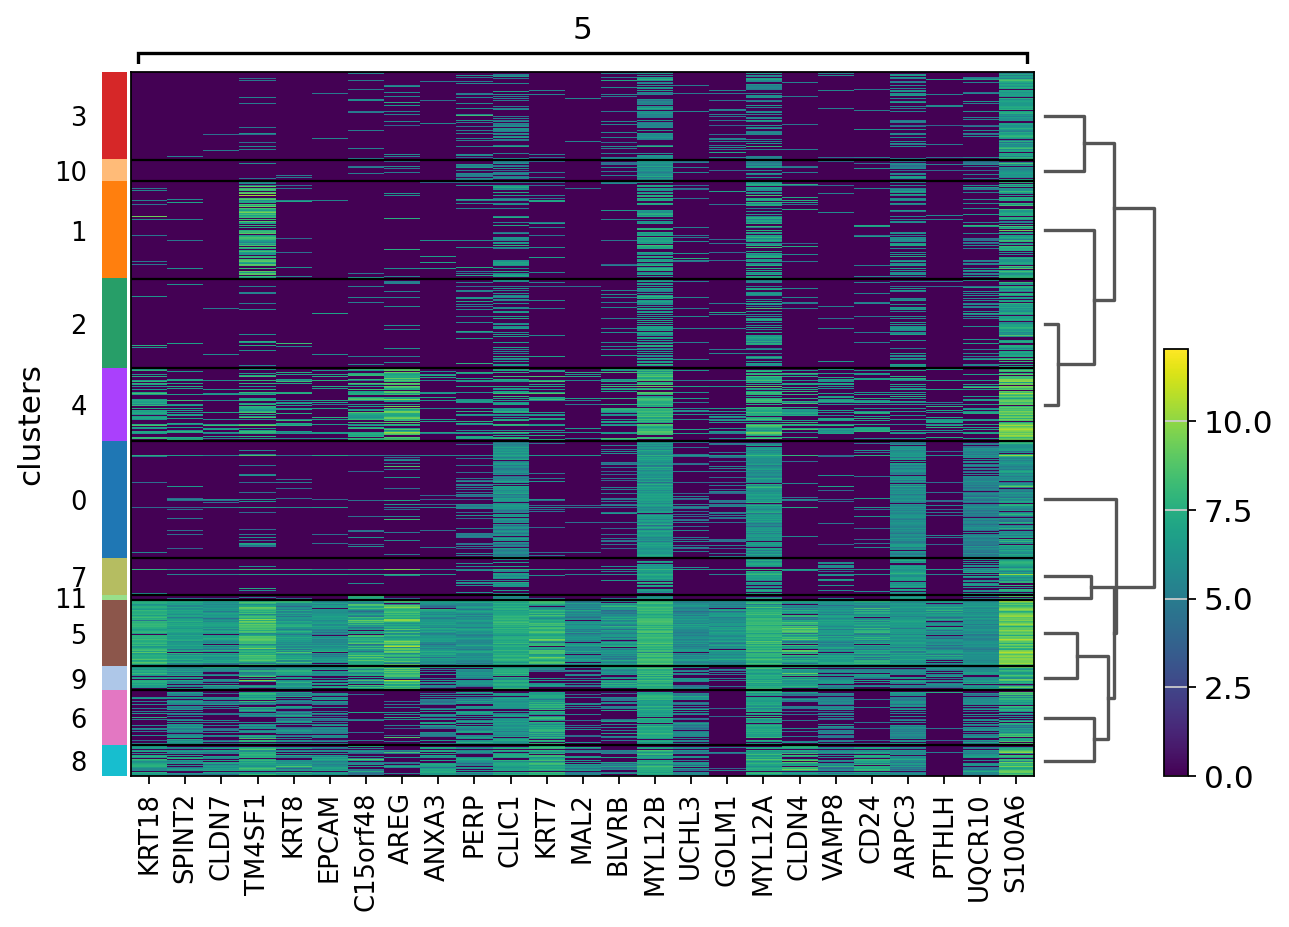

In [329]:
sc.tl.rank_genes_groups(data, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(data, groups="5", n_genes=25, groupby="clusters")

# Results and Discussion
- Cathepsin L (CTSL), is a lysosomal acid cysteine protease that has been reported to play a critical role in chemosensitivity and tumor progression. I has been found that CTSL served as a prognostic marker for poor clinical outcomes in Neuroblastoma patients [4] and breat cancer [5].
-  AREG has ben suggested as a valuable prognostic biomarker in invasive breast cancer and promising therapeutic targets, especially in ER-negative breast cancer [6]
- The study suggests co-expresion patterns of KRT8 and KRT 18 genes 8, 5 and 9. Previous studies have shown the co-expression of these genes in cancer breat patients [7].
- The expression of the HLA-DQA1 significantly upregulated in breast cancer a sin line with the previous findings [8].
-  IGFBP7 was reported to play tumor suppressive role in breast cancer[9]

# Conclusion
- This project has shown the co-expression pattersn for KRT8 and KRT 18 genes genes
- Most cancer associated genes are CTSL,AREG  and DCN

# References
https://tcr.amegroups.org/article/view/76142/html

1. Kim H, Whitman AA, Wisniewska K, Kakati RT, Garcia-Recio S, Calhoun BC, Franco HL, Perou CM, Spanheimer PM. Tamoxifen Response at Single Cell Resolution in Estrogen Receptor-Positive Primary Human Breast Tumors. bioRxiv [Preprint]. 2023 Apr 19:2023.04.01.535159. doi: 10.1101/2023.04.01.535159. Update in: Clin Cancer Res. 2023 Sep 25;: PMID: 37066379; PMCID: PMC10103953.
2. Wei Z, Shen Y, Zhou C, Cao Y, Deng H, Shen Z. CD3D: a prognostic biomarker associated with immune infiltration and immunotherapeutic response in head and neck squamous cell carcinoma. Bioengineered. 2022 May;13(5):13784-13800. doi: 10.1080/21655979.2022.2084254. PMID: 35712757; PMCID: PMC9276048.
3. Lu, J., Ahmad, R., Nguyen, T. et al. Heterogeneity and transcriptome changes of human CD8+ T cells across nine decades of life. Nat Commun 13, 5128 (2022). https://doi.org/10.1038/s41467-022-32869-x
4. Du, X., Ding, L., Huang, S., Li, F., Yan, Y., Tang, R., ... & Wang, W. (2022). Cathepsin L promotes chemresistance to neuroblastoma by modulating serglycin. Frontiers in Pharmacology, 13, 920022.
5. Zhang, L., Zhao, Y., Yang, J., Zhu, Y., Li, T., Liu, X., ... & Fu, J. (2023). CTSL, a prognostic marker of breast cancer, that promotes proliferation, migration, and invasion in cells in triple-negative breast cancer. Frontiers in Oncology, 13, 1158087.
6. Xiang, G., Liu, F., Liu, J., Meng, Q., Li, N., & Niu, Y. (2019). Prognostic role of Amphiregulin and the correlation with androgen receptor in invasive breast cancer. Pathology-Research and Practice, 215(6), 152414.
7. Wilson, C. A., & Dering, J. (2004). Recent translational research: microarray expression profiling of breast cancer–beyond classification and prognostic markers?. Breast Cancer Research, 6, 1-9.
8. Wu, G., Xiao, G., Yan, Y., Guo, C., Hu, N., & Shen, S. (2022). Bioinformatics analysis of the clinical significance of HLA class II in breast cancer. Medicine, 101(40).
9. Li, D., Xia, L., Huang, P., Wang, Z., Guo, Q., Huang, C., ... & Qin, S. (2023). Cancer-associated fibroblast-secreted IGFBP7 promotes gastric cancer by enhancing tumor associated macrophage infiltration via FGF2/FGFR1/PI3K/AKT axis. Cell Death Discovery, 9(1), 17.
10. https://www.sc-best-practices.org/introduction/analysis_tools.html